# XGBoost Model

In this notebook we train and evaluate an [XGBoost](https://xgboost.readthedocs.io) model. The model uses _gradient boosting_ on a random forest of decision trees, iteratively so as to focus subsequent trees on examples that were misclassified by the existing forest.

## Loading training data

In [1]:
import pandas as pd
import numpy as np

import os.path

training_data = pd.read_parquet(os.path.join("data", "training.parquet"))

In [2]:
training_data.sample(10)

,Category,Text
18345,misc.forsale,Non-smoking roommate needed\n to su...
17024,soc.religion.christian,\n seanna@bnr.ca (Seanna (S.M.) Watson) asks...
8757,sci.med,In article <C63zF3.7n5@mentor.cc.purdue.edu> s...
19411,talk.religion.misc,In article <1qsqar$n8m@usenet.INS.CWRU.Edu> ch...
8611,sci.med,In article <93111.145432ICGLN@ASUACAD.BITNET> ...
14454,sci.electronics,\n\tHere is a list I get when I was combing th...
13616,comp.sys.ibm.pc.hardware,It seems that there are a lot of questions reg...
1904,rec.autos,In article <3mwF2B1w165w@njcc.wisdom.bubble.or...
16357,sci.space,Sorry but I forgot this ps.\n\nRight now my si...
10836,rec.motorcycles,In article <1993Apr14.234835.1@cua.edu> 84wend...


## Feature Engineering

In [3]:
import cloudpickle as cp
feature_pipeline = cp.load(open('feature_pipeline.sav', 'rb'))

In [4]:
training_vecs = feature_pipeline.fit_transform(training_data["Text"])

## Training a model

In [5]:
from xgboost import XGBClassifier

In [6]:
%%time

XGB_TREE_METHOD='hist'
xgb = XGBClassifier(tree_method=XGB_TREE_METHOD, 
                    # num_parallel_tree=16, 
                    n_estimators=100, 
                    max_depth=3, 
                    colsample_bynode=0.3, 
                    colsample_bytree=0.3, 
                    subsample=1, 
                    reg_alpha=1)

xgb.fit(training_vecs, training_data["Category"])

CPU times: user 5min 35s, sys: 15.2 s, total: 5min 51s
Wall time: 52.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.3, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

## Evaluating model performance

In [7]:
xgb.score(training_vecs, training_data["Category"])

0.8830572883057288

In [8]:
testing_data = pd.read_parquet(os.path.join("data", "testing.parquet"))
testing_vecs=feature_pipeline.transform(testing_data["Text"])
xgb.score(testing_vecs, testing_data["Category"])

0.721599464614355

In [9]:
from mlworkflows import plot

df, chart =plot.confusion_matrix(testing_data["Category"], xgb.predict(testing_vecs))

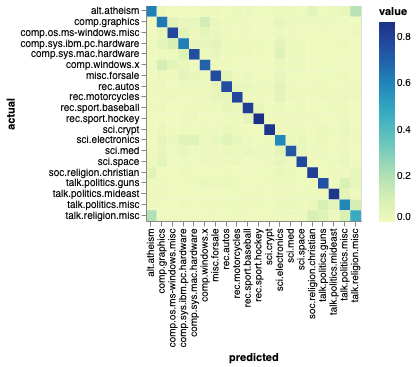

In [10]:
chart

In [11]:
from sklearn.metrics import classification_report
print(classification_report(testing_data["Category"], xgb.predict(testing_vecs)))

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.61      0.61       284
           comp.graphics       0.60      0.63      0.61       303
 comp.os.ms-windows.misc       0.76      0.77      0.77       293
comp.sys.ibm.pc.hardware       0.62      0.61      0.62       303
   comp.sys.mac.hardware       0.76      0.76      0.76       286
          comp.windows.x       0.67      0.69      0.68       280
            misc.forsale       0.71      0.76      0.74       305
               rec.autos       0.70      0.76      0.73       300
         rec.motorcycles       0.79      0.78      0.78       317
      rec.sport.baseball       0.80      0.81      0.80       291
        rec.sport.hockey       0.89      0.86      0.88       310
               sci.crypt       0.92      0.84      0.88       303
         sci.electronics       0.51      0.58      0.54       274
                 sci.med       0.79      0.72      0.76       314
         

✅ With the parameters selected above, the model performs better than the [random forest model](02-random-forest-model.ipynb). Are there any advantages to using the random forest model over the XGBoost model? 

✅ Try changing the parameters of the model - how does this affect the model's performance? 



In [12]:
from mlworkflows import util

util.serialize_to(xgb, "model.sav")